In [2]:
%%capture
pip install plotly pandas statsmodels kaleido scipy

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import numpy as np
import os.path
from math import log10

figures_directory = '../../paper-icse-2024-linux/figures'
figures_directory = '../output3'
default_height = 400

pio.templates['colorblind'] = go.layout.Template(layout_colorway=['#648FFF', '#FE6100', '#785EF0', '#DC267F', '#FFB000'])
pio.templates.default = 'plotly_white+colorblind'

def read_dataframe(file, dtype={}, usecols=None):
    if not file:
        file = 'output'
    df = pd.read_csv(file, dtype=dtype, usecols=usecols)
    df['old_revision_date'] = df['old_revision'].apply(lambda d: pd.to_datetime(d.split("-")[0]))
    df['new_revision_date'] = df['new_revision'].apply(lambda d: pd.to_datetime(d.split("-")[0]))
    return df

def replace_values(df):
    df.replace('kconfigreader', 'KConfigReader', inplace=True)
    df.replace('kmax', 'KClause', inplace=True)

def big_log10(str):
    return log10(int(str)) if not pd.isna(str) and str != '' else pd.NA

def process_model_count(df_solve):
    df_solve['model-count'] = df_solve['model-count'].replace('1', '')
    df_solve['model-count-log10'] = df_solve['model-count'].fillna('').apply(big_log10).replace(0, np.nan)
    df_solve['year'] = df_solve['committer_date'].apply(lambda d: int(d.year))

def committer_date_x_axis(fig, df, column='new_revision_date', step=1):
    axis = df[[column, 'year']].drop_duplicates()
    axis = axis.sort_values(by=column).groupby('year').nth(0).reset_index()
    fig.update_xaxes(
        ticktext=axis['year'][::step],
        tickvals=axis[column][::step]
    )

def log10_y_axis(fig):
    fig.update_yaxes(tickprefix = "10<sup>", ticksuffix = "</sup>")

def percentage_y_axis(fig):
    fig.layout.yaxis.tickformat = ',.0%'

def format_percentage(value):
    return str(round(value * 100, 2)) + '%'

def committer_date_labels(dict={}):
    return {'committer_date': 'Year / First Release in Year'} | dict

def revision_labels(dict={}):
    return {'revision': 'Year'} | dict

def style_legend(fig, position='topleft', xshift=0, yshift=0):
    if position == 'topleft':
        fig.update_layout(legend=dict(yanchor='top', y=0.98 + yshift, xanchor='left', x=0.01 + xshift))
    elif position == 'topright':
        fig.update_layout(legend=dict(yanchor='top', y=0.98 + yshift, xanchor='right', x=0.98 + xshift))
    elif position == 'bottomright':
        fig.update_layout(legend=dict(yanchor='bottom', y=0.01 + yshift, xanchor='right', x=0.98 + xshift))
    elif position == 'bottomleft':
        fig.update_layout(legend=dict(yanchor='bottom', y=0.01 + yshift, xanchor='left', x=0.01 + xshift))
    else:
        fig.update_layout(showlegend=False)

def style_box(fig, legend_position='topleft', xshift=0, yshift=0):
    fig.update_traces(fillcolor='rgba(0,0,0,0)')
    fig.update_traces(line_width=1)
    fig.update_traces(marker_size=2)
    style_legend(fig, legend_position, xshift, yshift)

def style_bar(fig, legend_position='topleft', xshift=0, yshift=0):
    fig.update_layout(bargap=0)
    style_legend(fig, legend_position, xshift, yshift)

def style_scatter(fig, marker_size=4, legend_position='topleft', xshift=0, yshift=0):
    if marker_size:
        fig.update_traces(marker_size=marker_size)
    style_legend(fig, legend_position, xshift, yshift)

def filter_extractor(df, extractor):
    return df[df['extractor'] == extractor]

def show(fig, name=None, width=1400, height=500, margin=None):
    fig.update_layout(width=width, height=height)
    if margin:
        fig.update_layout(margin=margin)
    else:
        fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
    if figures_directory and os.path.isdir(figures_directory) and name:
        fig.write_image(f'{figures_directory}/{name}.pdf')
    fig.show()

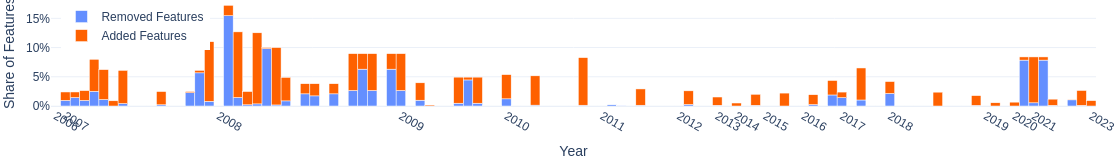

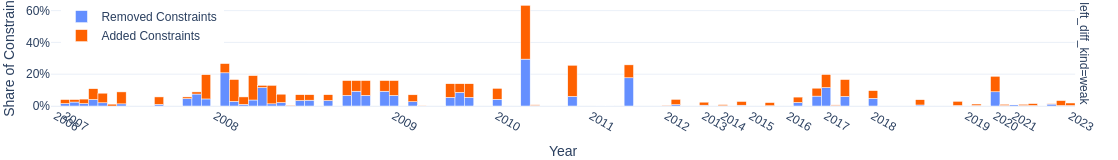

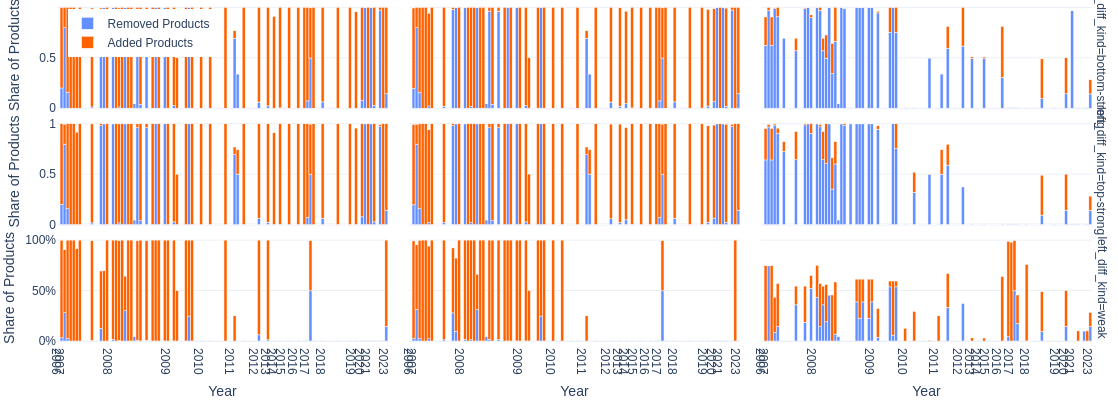

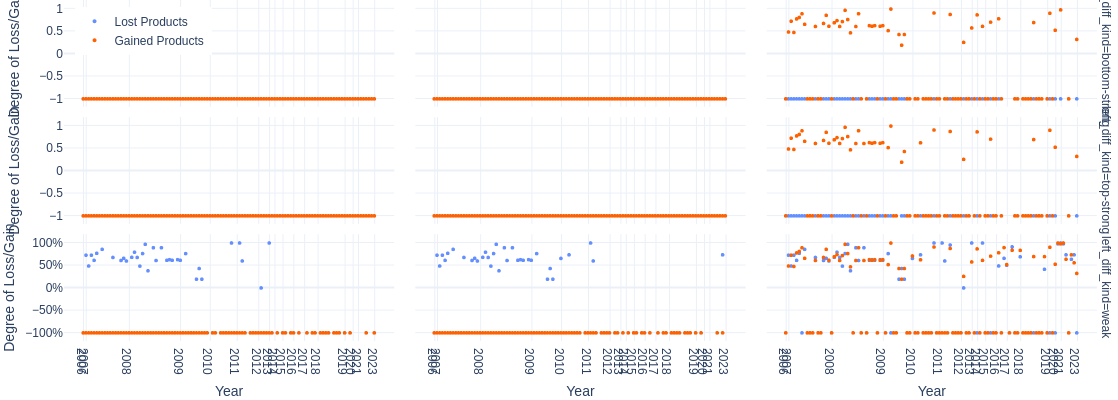

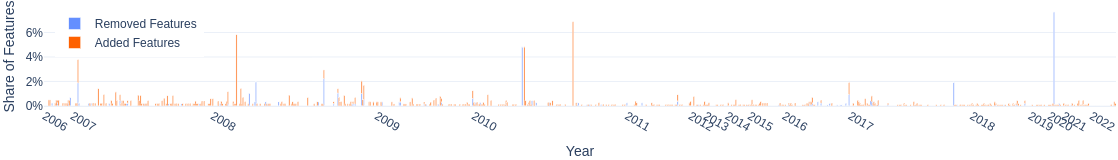

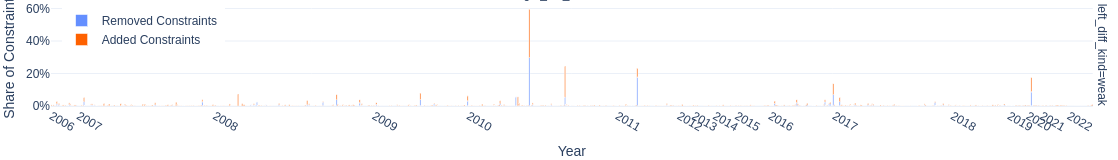

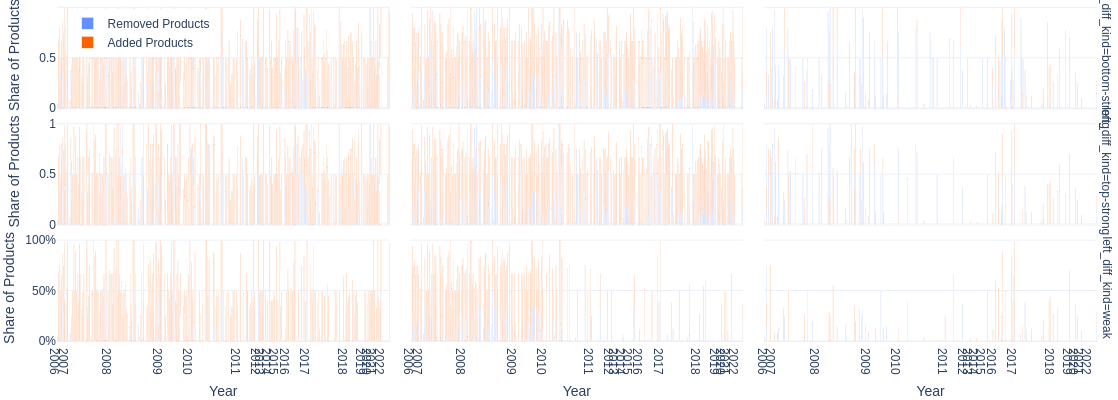

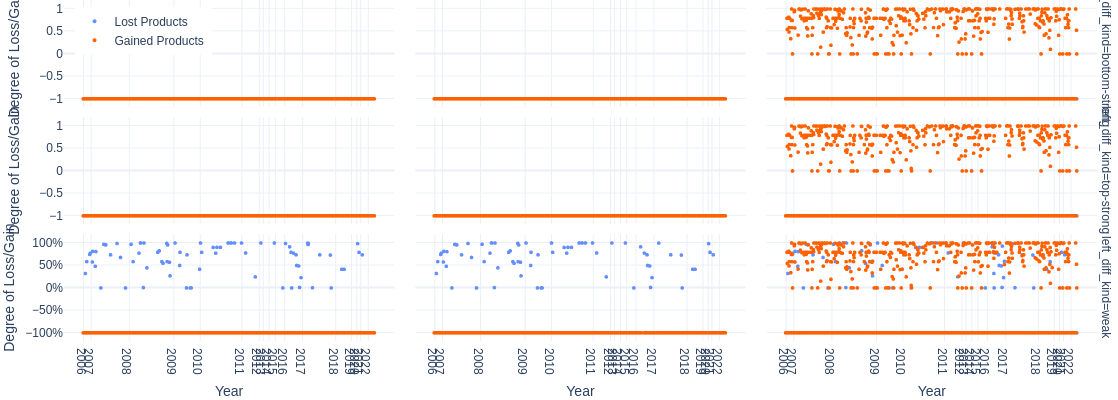

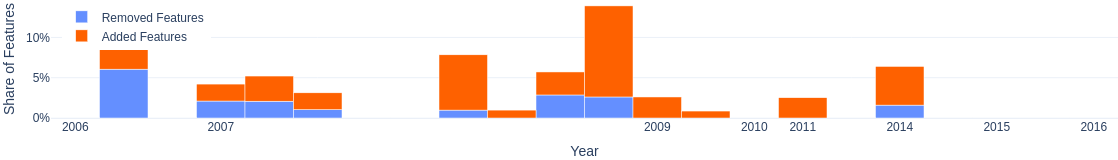

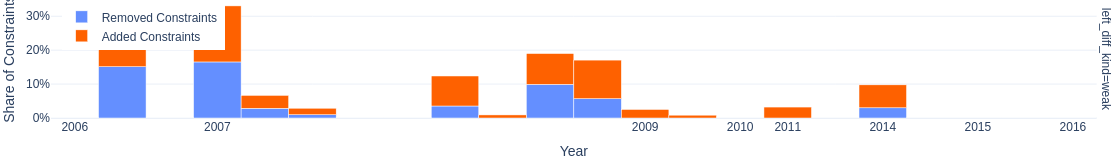

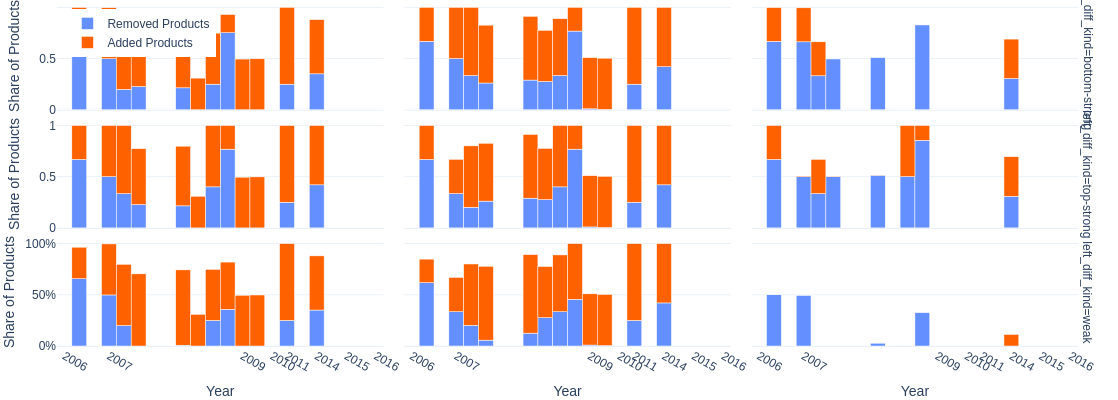

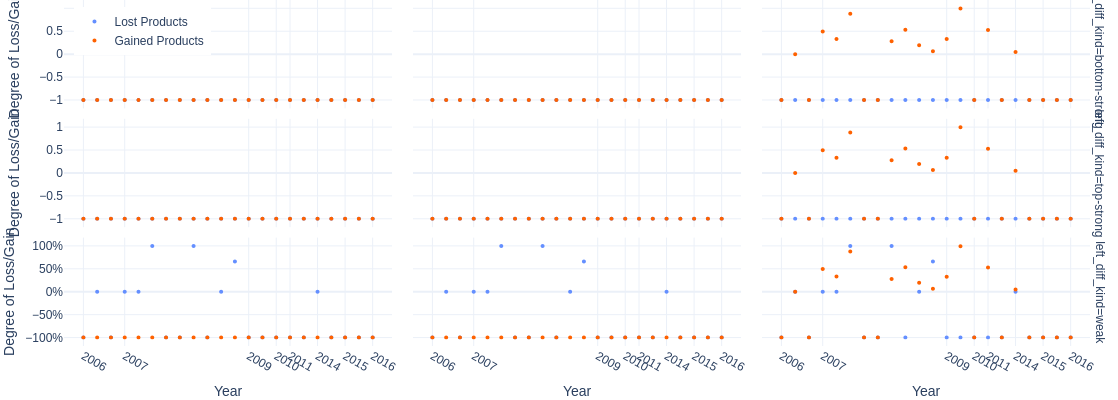

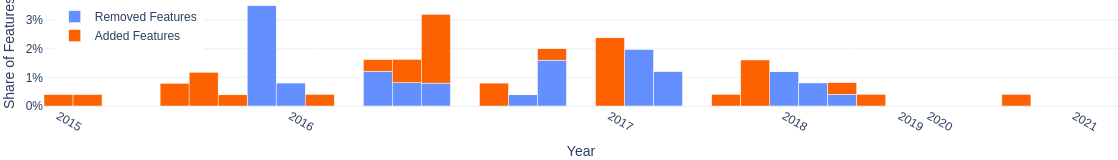

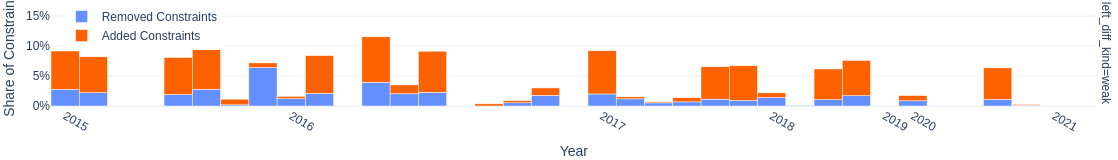

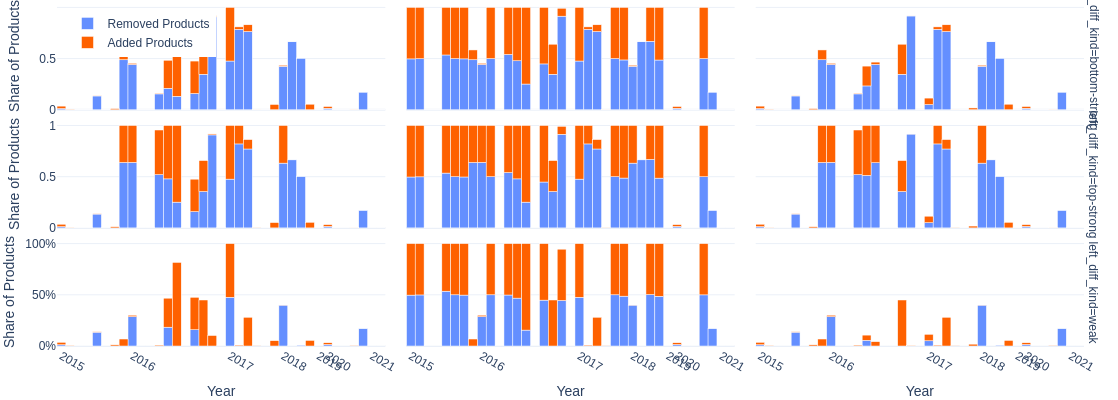

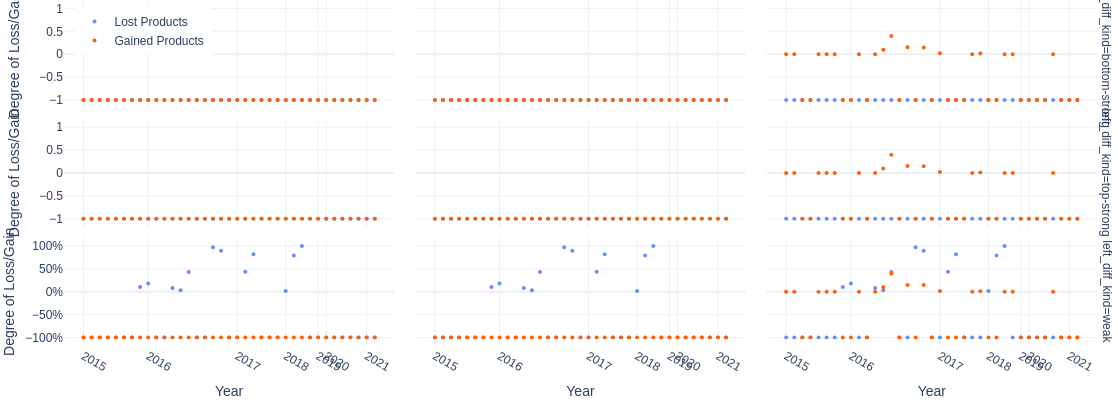

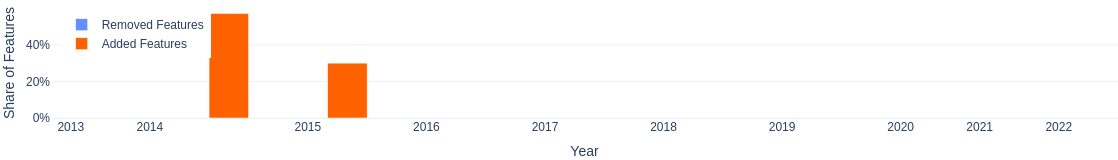

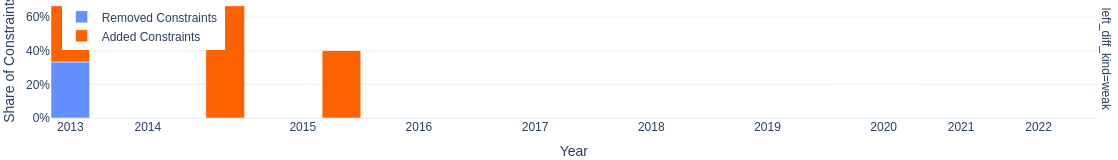

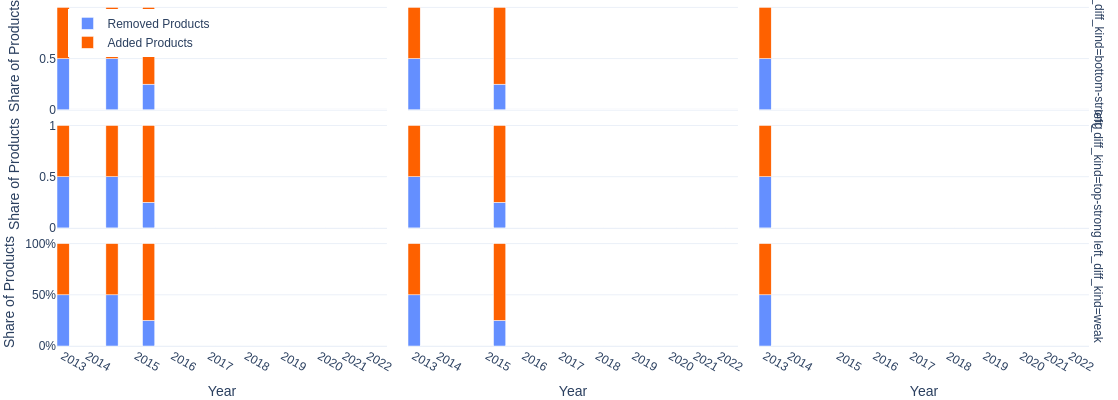

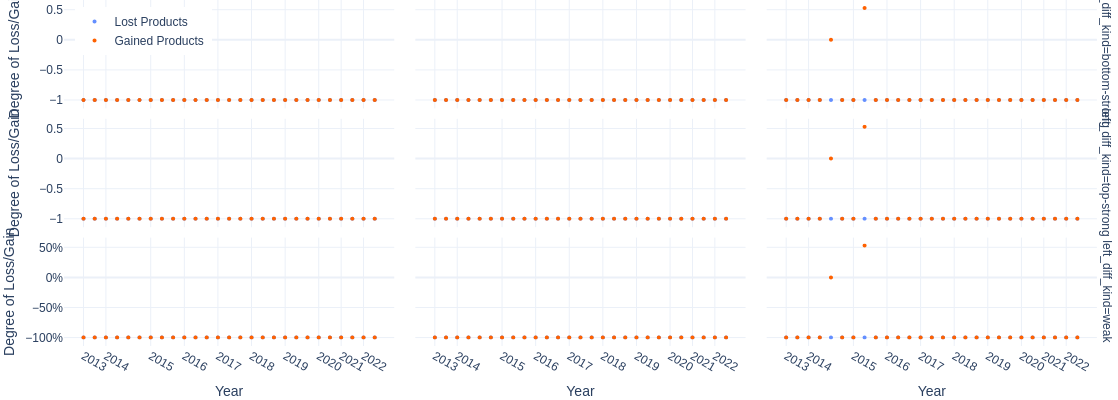

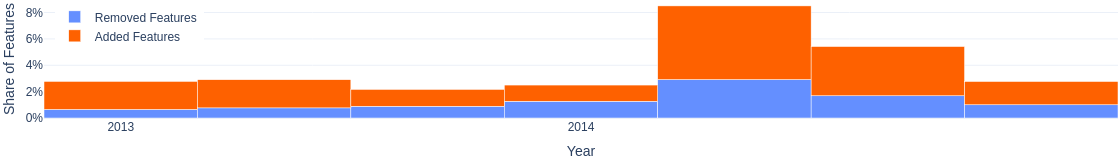

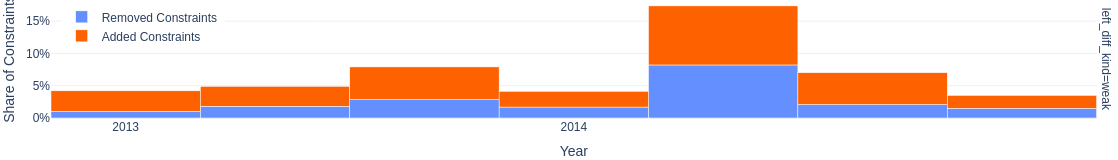

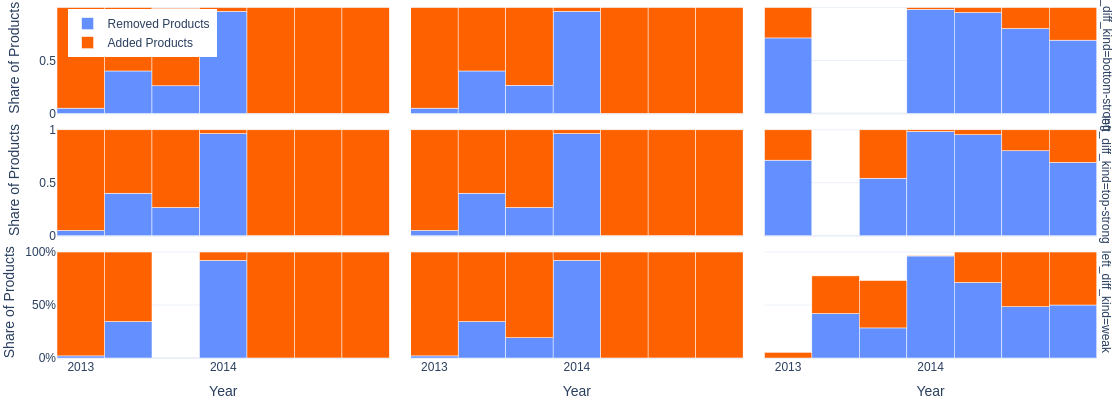

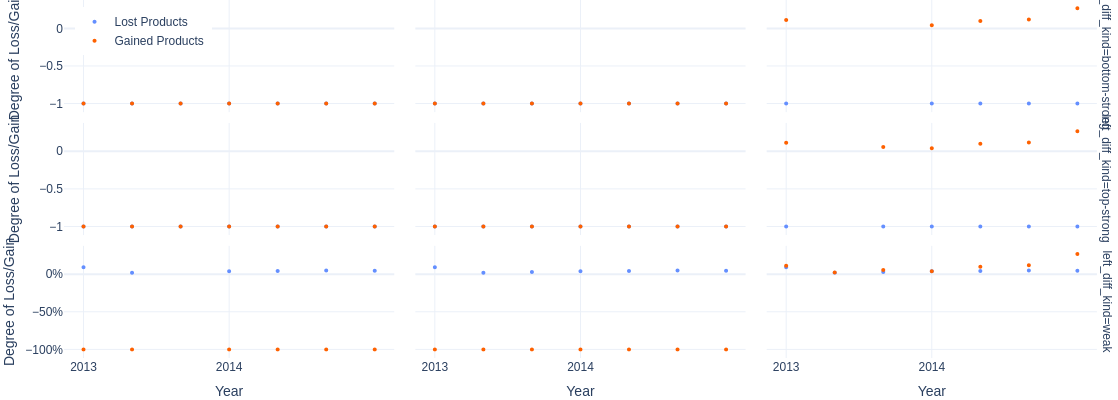

In [4]:
dfs = [read_dataframe(f'../output3/output_all/diff_{i}.csv') for i in range(1, 7)]

for df_diff in dfs:
    df_diff['year'] = df_diff['new_revision_date'].apply(lambda d: int(d.year))
    df_diff['total_features'] = df_diff['common_features'] + df_diff['removed_features'] + df_diff['added_features']
    df_diff['total_constraints'] = df_diff['common_constraints'] + df_diff['removed_constraints'] + df_diff['added_constraints']
    df_diff['common_features_rapio'] = df_diff['common_features'] / df_diff['total_features']
    df_diff['removed_features_ratio'] = df_diff['removed_features'] / df_diff['total_features']
    df_diff['added_features_ratio'] = df_diff['added_features'] / df_diff['total_features']
    df_diff['common_constraints_rapio'] = df_diff['common_constraints'] / df_diff['total_constraints']
    df_diff['removed_constraints_ratio'] = df_diff['removed_constraints'] / df_diff['total_constraints']
    df_diff['added_constraints_ratio'] = df_diff['added_constraints'] / df_diff['total_constraints']

    fig = px.bar(
        df_diff[(df_diff['left_diff_kind']=='weak')&(df_diff['right_diff_kind']=='weak')].rename(columns={'removed_features_ratio': 'Removed Features', 'added_features_ratio': 'Added Features'}),
        x='new_revision',
        y=['Removed Features', 'Added Features'],
        labels={'value': 'Share of Features', 'new_revision': 'Year', 'variable': ''},
    )
    committer_date_x_axis(fig, df_diff, column='new_revision')
    percentage_y_axis(fig)
    style_bar(fig)
    show(fig, 'features', height=0.4*default_height)

    fig = px.bar(
        df_diff[(df_diff['left_diff_kind']=='weak')&(df_diff['right_diff_kind']=='weak')].rename(columns={'removed_constraints_ratio': 'Removed Constraints', 'added_constraints_ratio': 'Added Constraints'}),
        x='new_revision',
        y=['Removed Constraints', 'Added Constraints'],
        labels={'value': 'Share of Constraints', 'new_revision': 'Year', 'variable': ''},
        facet_row='left_diff_kind',
        facet_col='right_diff_kind',
    )
    committer_date_x_axis(fig, df_diff, column='new_revision')
    percentage_y_axis(fig)
    style_bar(fig)
    show(fig, 'constraints', height=0.4*default_height)

    fig = px.bar(
        df_diff.rename(columns={'removed_products': 'Removed Products', 'added_products': 'Added Products'}),
        x='new_revision',
        y=['Removed Products', 'Added Products'],
        labels={'value': 'Share of Products', 'new_revision': 'Year', 'variable': ''},
        facet_row='left_diff_kind',
        facet_col='right_diff_kind',
    )
    committer_date_x_axis(fig, df_diff, column='new_revision')
    percentage_y_axis(fig)
    style_bar(fig)
    show(fig, 'products', height=default_height)

    fig = px.scatter(
        df_diff.rename(columns={'lost_products': 'Lost Products', 'gained_products': 'Gained Products'}),
        x='new_revision',
        y=['Lost Products', 'Gained Products'],
        labels={'value': 'Degree of Loss/Gain', 'new_revision': 'Year', 'variable': ''},
        facet_row='left_diff_kind',
        facet_col='right_diff_kind',
    )
    committer_date_x_axis(fig, df_diff, column='new_revision')
    percentage_y_axis(fig)
    style_scatter(fig)
    show(fig, 'products2', height=default_height)

# visualize time outs
# visualized time in box plot
# visualize loss and gain in the same diagram as main results